# Diagnósticos MACRO v0.2 - Validación de Colinealidad y Coeficientes

**Objetivo**: Validar colinealidad, investigar coeficientes anómalos y realizar diagnósticos del modelo MACRO v0.2 simplificado.

**Fecha**: 21 de diciembre de 2025


## 1. Configuración e Imports


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Statsmodels para VIF y diagnósticos
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from scipy import stats
from scipy.stats import shapiro, pearsonr

# Configuración
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Rutas
DATA_DIR = Path("../data/processed")
LOGS_DIR = Path("../data/logs")
OUTPUT_DIR = Path("../data/processed")

print("✅ Imports completados")


✅ Imports completados


## 2. Cargar Datos y Modelo


In [78]:
# Cargar dataset enriquecido
df = pd.read_csv(DATA_DIR / "gracia_merged_agg_barrio_anio_dataset_v02.csv")
print(f"Dataset cargado: {len(df)} observaciones")
print(f"Columnas: {df.columns.tolist()}")

# Cargar métricas del modelo
with open(LOGS_DIR / "macro_model_v02_simplified.json", 'r') as f:
    model_metrics = json.load(f)

print(f"\n✅ Modelo cargado: {model_metrics['model_version']}")
print(f"   R²: {model_metrics['test']['r2']:.4f}")
print(f"   RMSE: {model_metrics['test']['rmse']:.2f} €/m²")


Dataset cargado: 175 observaciones
Columnas: ['barrio_id', 'anio', 'dataset_id', 'n_obs', 'precio_m2_mean', 'precio_m2_std', 'superficie_m2_barrio_mean', 'ano_construccion_barrio_mean', 'plantas_barrio_mean', 'source', 'match_method', 'renta_promedio_barrio', 'renta_mediana_barrio', 'renta_min_barrio', 'renta_max_barrio', 'n_secciones_renta', 'poblacion_total', 'prop_hombres', 'prop_mujeres', 'prop_0_17', 'prop_18_34', 'prop_35_49', 'prop_50_64', 'prop_65_plus', 'prop_espana', 'prop_extranjeros']

✅ Modelo cargado: MACRO v0.2_simplified
   R²: 0.7952
   RMSE: 271.84 €/m²


## 3. Preparar Features para Análisis


In [79]:
# Features del modelo simplificado
features_numericas = [
    'superficie_m2_barrio_mean',
    'ano_construccion_barrio_mean',
    'plantas_barrio_mean',
    'anio',
    'renta_promedio_barrio',
    'renta_mediana_barrio'
]

# Filtrar dataset para análisis (incluir barrio_id para merges posteriores)
# Nota: 'anio' ya está en features_numericas, no duplicar
additional_cols = ['precio_m2_mean', 'dataset_id', 'barrio_id']
# Asegurar que no haya duplicados en columnas
all_cols = list(dict.fromkeys(features_numericas + additional_cols))  # dict.fromkeys preserva orden y elimina duplicados
df_analysis = df[all_cols].copy()

# Resetear índice si hay duplicados para evitar problemas con máscaras booleanas
if df_analysis.index.duplicated().any():
    df_analysis = df_analysis.reset_index(drop=True)
    print("⚠️  Índice duplicado detectado y reseteado")

# Imputar valores faltantes con mediana
for col in features_numericas:
    if col in df_analysis.columns:
        col_data = df_analysis[col]
        # Si es DataFrame (columnas duplicadas), tomar la primera columna
        if isinstance(col_data, pd.DataFrame):
            col_series = col_data.iloc[:, 0]
        else:
            col_series = col_data
        
        isna_result = col_series.isna()
        sum_result = isna_result.sum()
        
        # Solución robusta: manejar diferentes tipos de resultados
        try:
            if isinstance(sum_result, pd.Series):
                # Si es Series, tomar el primer valor
                na_count = int(sum_result.iloc[0]) if len(sum_result) > 0 else 0
            elif isinstance(sum_result, (np.integer, np.floating)):
                # Si es numpy scalar, convertir directamente
                na_count = int(sum_result)
            else:
                # Intentar convertir a escalar usando numpy
                na_count = int(np.asarray(sum_result).item())
        except (ValueError, TypeError, AttributeError):
            # Fallback final: convertir a lista y tomar el primer elemento
            try:
                na_count = int(list(np.asarray(sum_result).flatten())[0])
            except:
                na_count = 0
        
        if na_count > 0:
            median_val = float(df_analysis[col].median())
            df_analysis[col] = df_analysis[col].fillna(median_val)
            print(f"Imputado {col}: {na_count} valores con mediana ({median_val:.2f})")

print(f"\n✅ Dataset preparado: {len(df_analysis)} observaciones")
print(f"   Features numéricas: {len(features_numericas)}")


Imputado renta_promedio_barrio: 55 valores con mediana (24863.03)
Imputado renta_mediana_barrio: 55 valores con mediana (24863.03)

✅ Dataset preparado: 175 observaciones
   Features numéricas: 6


## 4. Matriz de Correlaciones


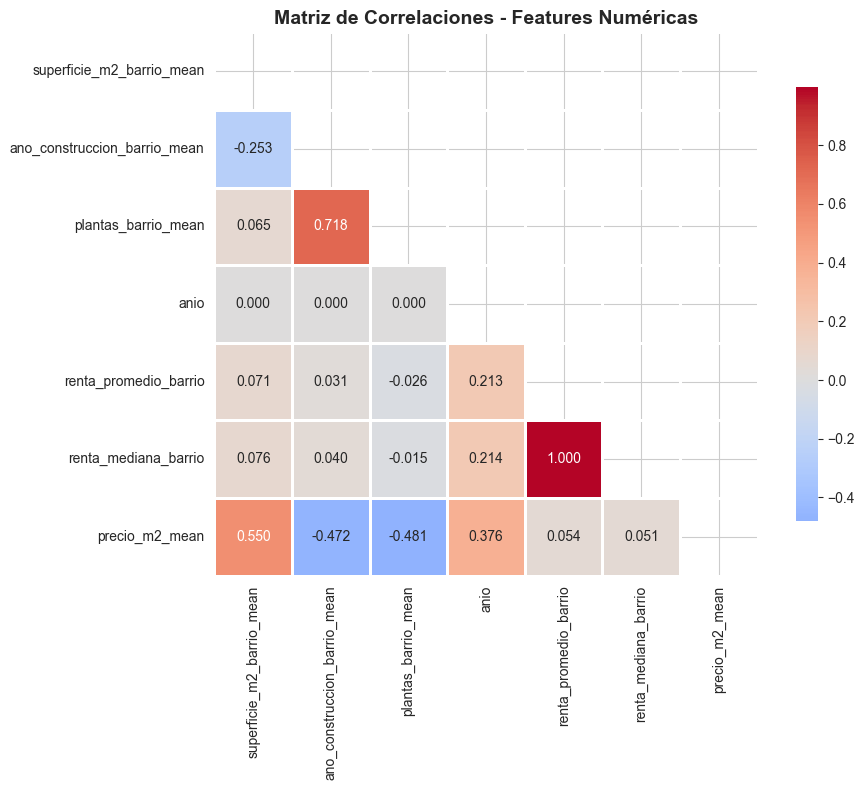


📊 Correlaciones Altas (|r| > 0.7):
   ano_construccion_barrio_mean ↔ plantas_barrio_mean: 0.718
   renta_promedio_barrio ↔ renta_mediana_barrio: 1.000


In [80]:
# Calcular matriz de correlaciones
corr_matrix = df_analysis[features_numericas + ['precio_m2_mean']].corr()

# Visualizar
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8}
)
plt.title("Matriz de Correlaciones - Features Numéricas", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "correlation_matrix_macro_v02.png", dpi=150, bbox_inches='tight')
plt.show()

# Análisis de correlaciones altas
print("\n📊 Correlaciones Altas (|r| > 0.7):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

if high_corr:
    for feat1, feat2, corr in high_corr:
        print(f"   {feat1} ↔ {feat2}: {corr:.3f}")
else:
    print("   ✅ No hay correlaciones altas detectadas")


## 5. Análisis de Colinealidad: VIF (Variance Inflation Factor)


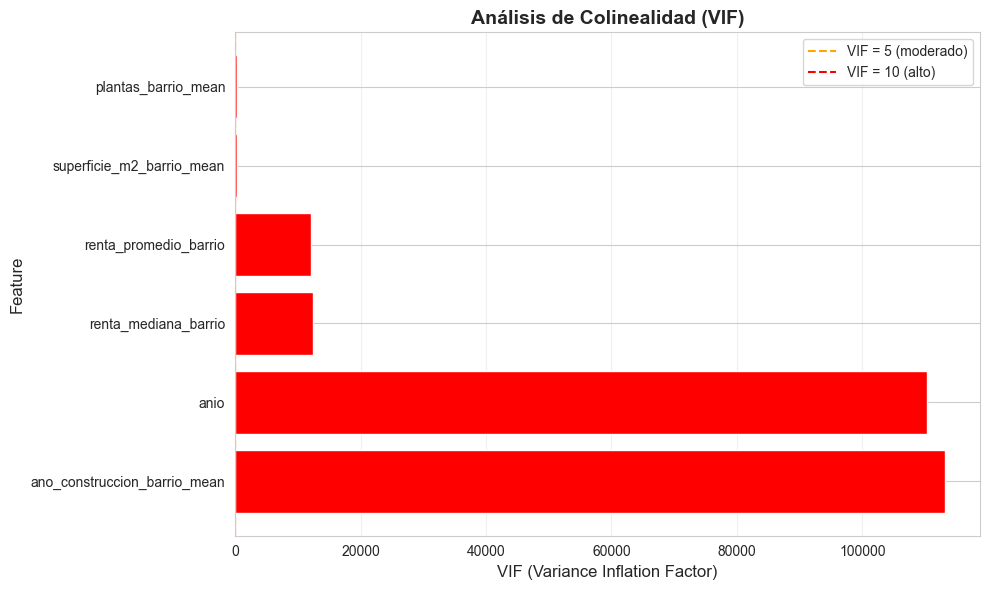


📊 VIF por Feature:
                     Feature           VIF
ano_construccion_barrio_mean 113084.341182
                        anio 110290.239224
        renta_mediana_barrio  12394.754947
       renta_promedio_barrio  12069.940689
   superficie_m2_barrio_mean    296.243078
         plantas_barrio_mean    273.610185

📋 Interpretación VIF:
   VIF < 5: ✅ Sin colinealidad significativa
   5 ≤ VIF < 10: ⚠️  Colinealidad moderada
   VIF ≥ 10: ❌ Colinealidad alta (problema)

   ⚠️  Features con VIF ≥ 10: 6
      - ano_construccion_barrio_mean: VIF = 113084.34
      - anio: VIF = 110290.24
      - renta_mediana_barrio: VIF = 12394.75
      - renta_promedio_barrio: VIF = 12069.94
      - superficie_m2_barrio_mean: VIF = 296.24
      - plantas_barrio_mean: VIF = 273.61


In [81]:
# Preparar datos para VIF (sin intercept, ya que VIF del intercept no es interpretable)
X = df_analysis[features_numericas].copy()

# Calcular VIF (sin intercept)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Ordenar por VIF
vif_data = vif_data.sort_values('VIF', ascending=False)

# Visualizar
plt.figure(figsize=(10, 6))
colors = ['red' if v > 10 else 'orange' if v > 5 else 'green' for v in vif_data['VIF']]
bars = plt.barh(vif_data['Feature'], vif_data['VIF'], color=colors)
plt.axvline(x=5, color='orange', linestyle='--', label='VIF = 5 (moderado)')
plt.axvline(x=10, color='red', linestyle='--', label='VIF = 10 (alto)')
plt.xlabel('VIF (Variance Inflation Factor)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Análisis de Colinealidad (VIF)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "vif_analysis_macro_v02.png", dpi=150, bbox_inches='tight')
plt.show()

# Mostrar tabla
print("\n📊 VIF por Feature:")
print(vif_data.to_string(index=False))

# Interpretación
print("\n📋 Interpretación VIF:")
print("   VIF < 5: ✅ Sin colinealidad significativa")
print("   5 ≤ VIF < 10: ⚠️  Colinealidad moderada")
print("   VIF ≥ 10: ❌ Colinealidad alta (problema)")

high_vif = vif_data[vif_data['VIF'] >= 10]
if len(high_vif) > 0:
    print(f"\n   ⚠️  Features con VIF ≥ 10: {len(high_vif)}")
    for _, row in high_vif.iterrows():
        print(f"      - {row['Feature']}: VIF = {row['VIF']:.2f}")
else:
    print("\n   ✅ No hay features con VIF ≥ 10")


## 6. Análisis Específico: renta_promedio vs renta_mediana


📊 Correlación renta_promedio ↔ renta_mediana: 0.9995


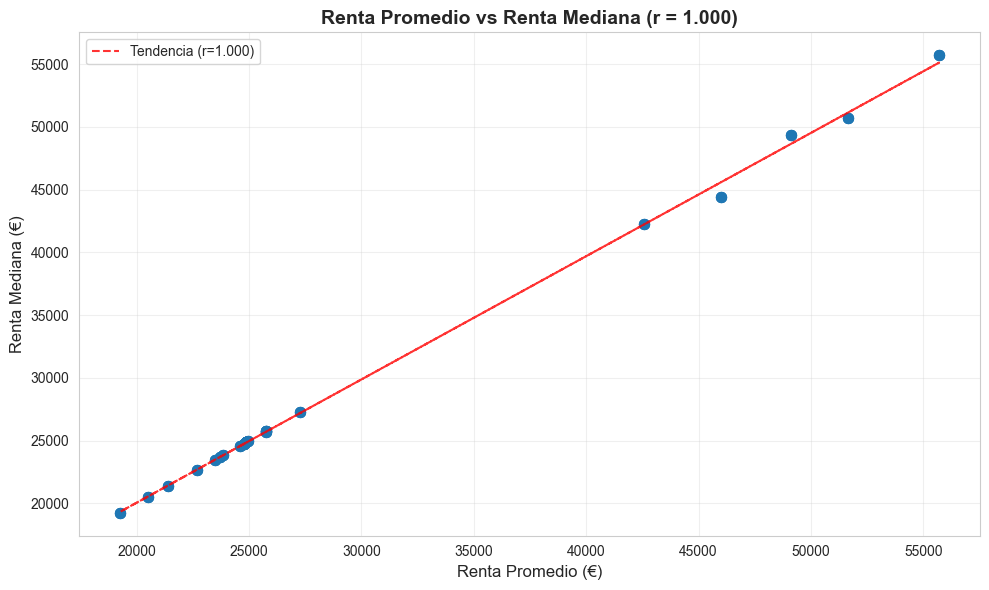


📊 Estadísticas Descriptivas:
       renta_promedio_barrio  renta_mediana_barrio
count             175.000000            175.000000
mean            28505.151359          28416.686954
std              9665.034393           9497.175635
min             19257.800000          19257.800000
25%             24612.272727          24612.272727
50%             24863.030556          24863.030556
75%             25749.090909          25749.090909
max             55698.181818          55718.000000

   ⚠️  RECOMENDACIÓN: Alta colinealidad detectada (r > 0.9)
      Considerar eliminar una de las dos features (renta_mediana_barrio)


In [82]:
# Análisis de correlación entre renta_promedio y renta_mediana
corr_renta = df_analysis[['renta_promedio_barrio', 'renta_mediana_barrio']].corr().iloc[0, 1]

print(f"📊 Correlación renta_promedio ↔ renta_mediana: {corr_renta:.4f}")

# Visualizar scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    df_analysis['renta_promedio_barrio'],
    df_analysis['renta_mediana_barrio'],
    alpha=0.6,
    s=50
)
plt.xlabel('Renta Promedio (€)', fontsize=12)
plt.ylabel('Renta Mediana (€)', fontsize=12)
plt.title(f'Renta Promedio vs Renta Mediana (r = {corr_renta:.3f})', fontsize=14, fontweight='bold')

# Añadir línea de regresión
z = np.polyfit(df_analysis['renta_promedio_barrio'], df_analysis['renta_mediana_barrio'], 1)
p = np.poly1d(z)
plt.plot(df_analysis['renta_promedio_barrio'], p(df_analysis['renta_promedio_barrio']), "r--", alpha=0.8, label=f'Tendencia (r={corr_renta:.3f})')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "renta_correlation_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

# Estadísticas descriptivas
print("\n📊 Estadísticas Descriptivas:")
print(df_analysis[['renta_promedio_barrio', 'renta_mediana_barrio']].describe())

# Recomendación
if abs(corr_renta) > 0.9:
    print("\n   ⚠️  RECOMENDACIÓN: Alta colinealidad detectada (r > 0.9)")
    print("      Considerar eliminar una de las dos features (renta_mediana_barrio)")
elif abs(corr_renta) > 0.7:
    print("\n   ⚠️  RECOMENDACIÓN: Colinealidad moderada detectada (r > 0.7)")
    print("      Revisar si ambas features son necesarias")
else:
    print("\n   ✅ Correlación aceptable (r < 0.7)")


## 7. Investigación: Coeficiente Anómalo de plantas_barrio_mean


📊 Coeficiente plantas_barrio_mean: -826.8622
   Interpretación: Cada planta adicional reduce precio/m² en 826.86 €/m²

📊 Estadísticas de plantas_barrio_mean:
count    175.000000
mean       5.183333
std        0.482699
min        4.416667
25%        4.833333
50%        5.416667
75%        5.583333
max        5.666667
Name: plantas_barrio_mean, dtype: float64


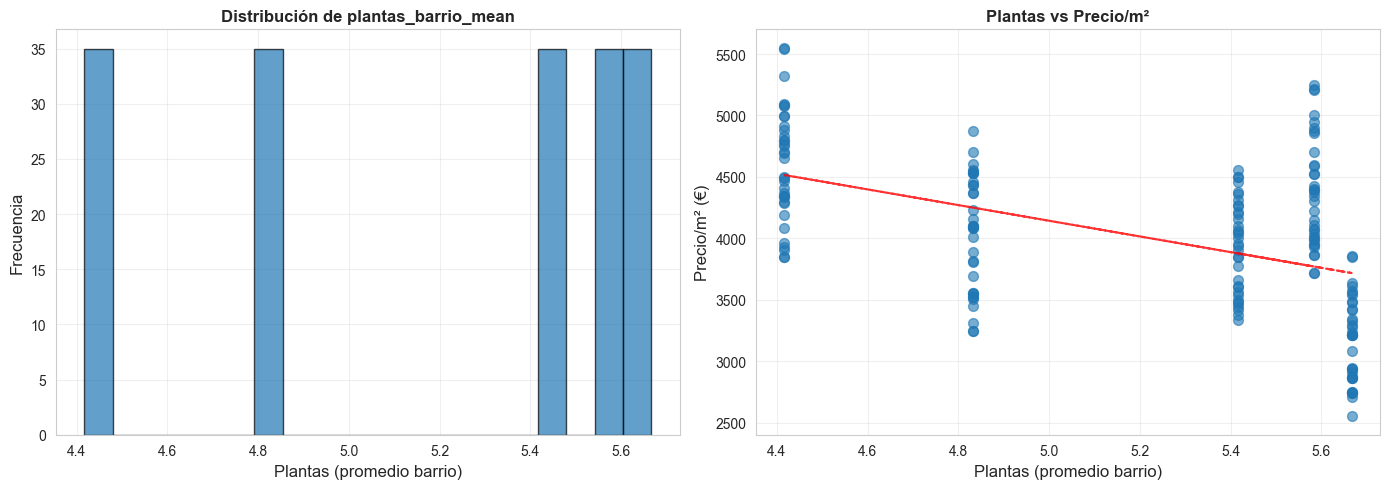


📊 Correlación plantas_barrio_mean ↔ precio_m2_mean: -0.4811

📊 Outliers detectados: 0 observaciones


In [83]:
# Coeficiente del modelo
coef_plantas = model_metrics['coefficients'].get('plantas_barrio_mean', 0)
print(f"📊 Coeficiente plantas_barrio_mean: {coef_plantas:.4f}")
print(f"   Interpretación: Cada planta adicional reduce precio/m² en {abs(coef_plantas):.2f} €/m²")

# Análisis exploratorio de plantas_barrio_mean
print("\n📊 Estadísticas de plantas_barrio_mean:")
print(df_analysis['plantas_barrio_mean'].describe())

# Visualizar distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(df_analysis['plantas_barrio_mean'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Plantas (promedio barrio)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de plantas_barrio_mean', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Scatter plot: plantas vs precio_m2
axes[1].scatter(
    df_analysis['plantas_barrio_mean'],
    df_analysis['precio_m2_mean'],
    alpha=0.6,
    s=50
)
axes[1].set_xlabel('Plantas (promedio barrio)', fontsize=12)
axes[1].set_ylabel('Precio/m² (€)', fontsize=12)
axes[1].set_title('Plantas vs Precio/m²', fontsize=12, fontweight='bold')

# Añadir línea de regresión
z = np.polyfit(df_analysis['plantas_barrio_mean'], df_analysis['precio_m2_mean'], 1)
p = np.poly1d(z)
axes[1].plot(df_analysis['plantas_barrio_mean'], p(df_analysis['plantas_barrio_mean']), "r--", alpha=0.8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plantas_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

# Correlación
corr_plantas = df_analysis[['plantas_barrio_mean', 'precio_m2_mean']].corr().iloc[0, 1]
print(f"\n📊 Correlación plantas_barrio_mean ↔ precio_m2_mean: {corr_plantas:.4f}")

# Análisis de outliers
Q1 = df_analysis['plantas_barrio_mean'].quantile(0.25)
Q3 = df_analysis['plantas_barrio_mean'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_analysis[(df_analysis['plantas_barrio_mean'] < Q1 - 1.5*IQR) | 
                       (df_analysis['plantas_barrio_mean'] > Q3 + 1.5*IQR)]
print(f"\n📊 Outliers detectados: {len(outliers)} observaciones")
if len(outliers) > 0:
    print(f"   Rango de outliers: {outliers['plantas_barrio_mean'].min():.2f} - {outliers['plantas_barrio_mean'].max():.2f}")


## 8. Análisis de Residuos


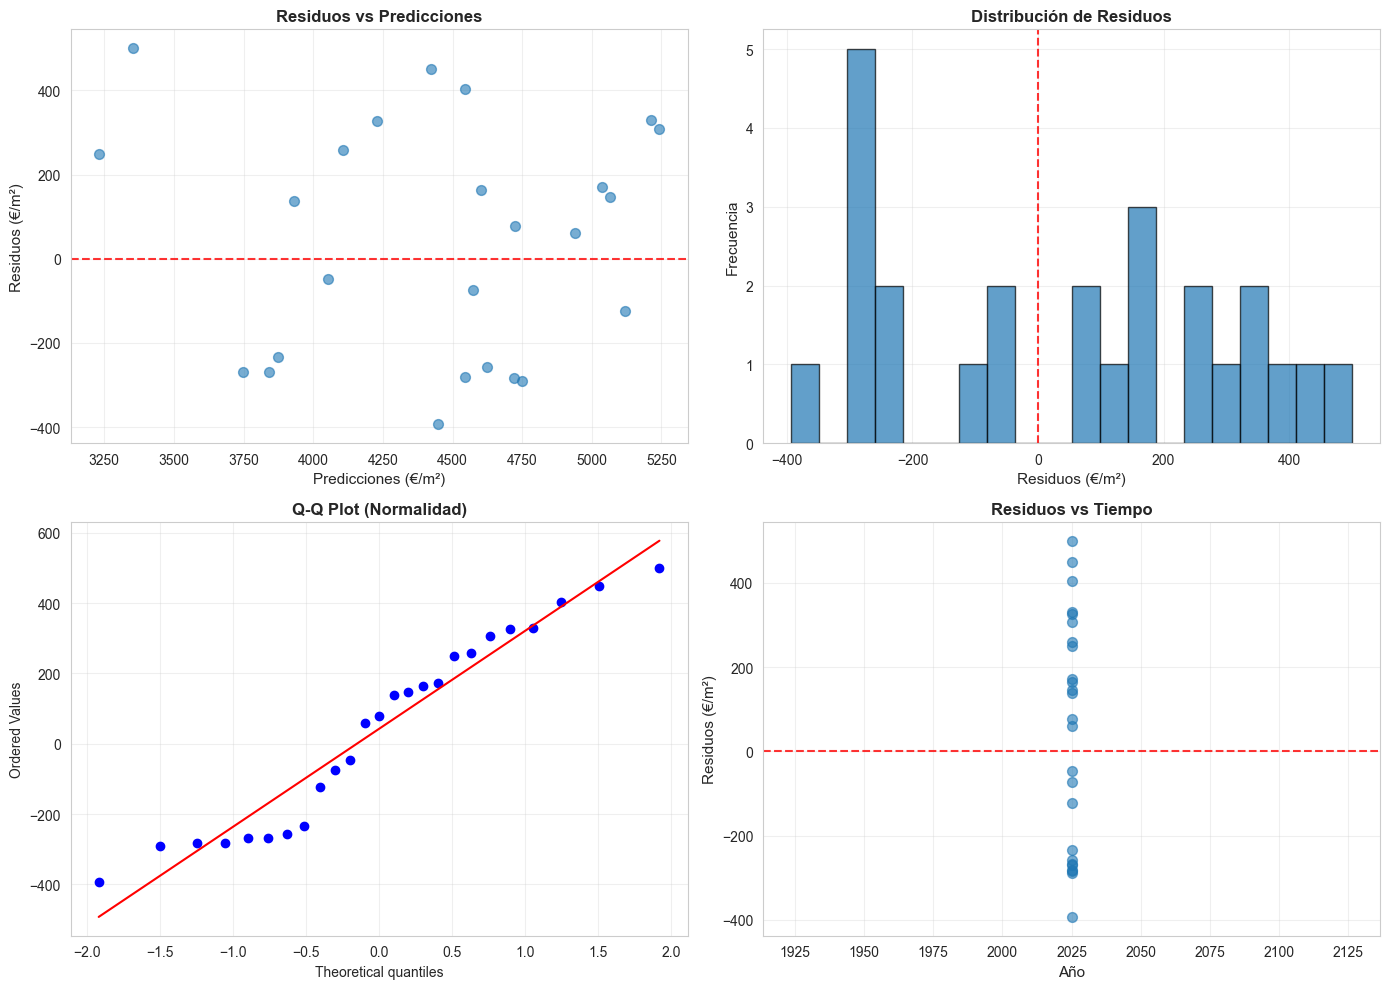


📊 Estadísticas de Residuos:
   Media: 42.50 €/m²
   Desviación estándar: 274.03 €/m²
   Min: -393.25 €/m²
   Max: 500.15 €/m²

📊 Test de Normalidad (Shapiro-Wilk):
   Estadístico: 0.9285
   p-value: 0.0804
   ✅ Residuos normalmente distribuidos (p > 0.05)


In [84]:
# Cargar predicciones
pred_df = pd.read_csv(OUTPUT_DIR / "macro_predictions_v02_simplified.csv")

# Calcular residuos
pred_df['residual'] = pred_df['precio_m2_mean_true'] - pred_df['precio_m2_mean_pred']

# Visualizar residuos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuos vs Predicciones
axes[0, 0].scatter(pred_df['precio_m2_mean_pred'], pred_df['residual'], alpha=0.6, s=50)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[0, 0].set_xlabel('Predicciones (€/m²)', fontsize=11)
axes[0, 0].set_ylabel('Residuos (€/m²)', fontsize=11)
axes[0, 0].set_title('Residuos vs Predicciones', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 2. Histograma de residuos
axes[0, 1].hist(pred_df['residual'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', alpha=0.8)
axes[0, 1].set_xlabel('Residuos (€/m²)', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].set_title('Distribución de Residuos', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Q-Q plot (normalidad)
stats.probplot(pred_df['residual'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. Residuos vs Año
if 'anio' in pred_df.columns:
    axes[1, 1].scatter(pred_df['anio'], pred_df['residual'], alpha=0.6, s=50)
    axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
    axes[1, 1].set_xlabel('Año', fontsize=11)
    axes[1, 1].set_ylabel('Residuos (€/m²)', fontsize=11)
    axes[1, 1].set_title('Residuos vs Tiempo', fontsize=12, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "residuals_analysis_macro_v02.png", dpi=150, bbox_inches='tight')
plt.show()

# Estadísticas de residuos
print("\n📊 Estadísticas de Residuos:")
print(f"   Media: {pred_df['residual'].mean():.2f} €/m²")
print(f"   Desviación estándar: {pred_df['residual'].std():.2f} €/m²")
print(f"   Min: {pred_df['residual'].min():.2f} €/m²")
print(f"   Max: {pred_df['residual'].max():.2f} €/m²")

# Test de normalidad (Shapiro-Wilk)
stat, p_value = shapiro(pred_df['residual'])
print(f"\n📊 Test de Normalidad (Shapiro-Wilk):")
print(f"   Estadístico: {stat:.4f}")
print(f"   p-value: {p_value:.4f}")
if p_value > 0.05:
    print(f"   ✅ Residuos normalmente distribuidos (p > 0.05)")
else:
    print(f"   ⚠️  Residuos NO normalmente distribuidos (p ≤ 0.05)")


## 9. Resumen y Recomendaciones


In [85]:
# Generar resumen de diagnósticos
summary = {
    'fecha': pd.Timestamp.now().isoformat(),
    'modelo': 'MACRO v0.2 (simplificado)',
    'diagnosticos': {}
}

# VIF
high_vif = vif_data[vif_data['VIF'] >= 10]
moderate_vif = vif_data[(vif_data['VIF'] >= 5) & (vif_data['VIF'] < 10)]
summary['diagnosticos']['vif'] = {
    'alto': int(len(high_vif)),
    'moderado': int(len(moderate_vif)),
    'aceptable': int(len(vif_data) - len(high_vif) - len(moderate_vif))
}

# Correlación renta
summary['diagnosticos']['correlacion_renta'] = {
    'valor': float(corr_renta),
    'interpretacion': 'alta' if abs(corr_renta) > 0.9 else 'moderada' if abs(corr_renta) > 0.7 else 'baja'
}

# Coeficiente plantas
summary['diagnosticos']['coeficiente_plantas'] = {
    'valor': float(coef_plantas),
    'interpretacion': 'anomalo' if abs(coef_plantas) > 500 else 'normal'
}

# Normalidad residuos
summary['diagnosticos']['normalidad_residuos'] = {
    'p_value': float(p_value),
    'normal': bool(p_value > 0.05)
}

# Guardar resumen
with open(OUTPUT_DIR / "diagnosticos_macro_v02_summary.json", 'w') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("\n" + "="*70)
print("RESUMEN DE DIAGNÓSTICOS")
print("="*70)
print(f"\n📊 Colinealidad (VIF):")
print(f"   Alto (VIF ≥ 10): {summary['diagnosticos']['vif']['alto']}")
print(f"   Moderado (5 ≤ VIF < 10): {summary['diagnosticos']['vif']['moderado']}")
print(f"   Aceptable (VIF < 5): {summary['diagnosticos']['vif']['aceptable']}")

print(f"\n📊 Correlación renta_promedio ↔ renta_mediana:")
print(f"   Valor: {summary['diagnosticos']['correlacion_renta']['valor']:.4f}")
print(f"   Interpretación: {summary['diagnosticos']['correlacion_renta']['interpretacion']}")

print(f"\n📊 Coeficiente plantas_barrio_mean:")
print(f"   Valor: {summary['diagnosticos']['coeficiente_plantas']['valor']:.4f}")
print(f"   Interpretación: {summary['diagnosticos']['coeficiente_plantas']['interpretacion']}")

print(f"\n📊 Normalidad de Residuos:")
print(f"   p-value: {summary['diagnosticos']['normalidad_residuos']['p_value']:.4f}")
print(f"   Normal: {'✅ Sí' if summary['diagnosticos']['normalidad_residuos']['normal'] else '❌ No'}")

print("\n" + "="*70)
print("RECOMENDACIONES")
print("="*70)

recommendations = []

if summary['diagnosticos']['vif']['alto'] > 0:
    recommendations.append("⚠️  Eliminar features con VIF ≥ 10")

if summary['diagnosticos']['correlacion_renta']['interpretacion'] in ['alta', 'moderada']:
    recommendations.append("⚠️  Considerar eliminar renta_mediana_barrio (alta colinealidad con renta_promedio_barrio)")

if summary['diagnosticos']['coeficiente_plantas']['interpretacion'] == 'anomalo':
    recommendations.append("⚠️  Investigar coeficiente anómalo de plantas_barrio_mean (posible colinealidad o error en datos)")

if not summary['diagnosticos']['normalidad_residuos']['normal']:
    recommendations.append("⚠️  Residuos no normales: considerar transformaciones o modelos robustos")

if not recommendations:
    recommendations.append("✅ No se detectaron problemas significativos")

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print(f"\n✅ Resumen guardado: {OUTPUT_DIR / 'diagnosticos_macro_v02_summary.json'}")



RESUMEN DE DIAGNÓSTICOS

📊 Colinealidad (VIF):
   Alto (VIF ≥ 10): 6
   Moderado (5 ≤ VIF < 10): 0
   Aceptable (VIF < 5): 0

📊 Correlación renta_promedio ↔ renta_mediana:
   Valor: 0.9995
   Interpretación: alta

📊 Coeficiente plantas_barrio_mean:
   Valor: -826.8622
   Interpretación: anomalo

📊 Normalidad de Residuos:
   p-value: 0.0804
   Normal: ✅ Sí

RECOMENDACIONES
1. ⚠️  Eliminar features con VIF ≥ 10
2. ⚠️  Considerar eliminar renta_mediana_barrio (alta colinealidad con renta_promedio_barrio)
3. ⚠️  Investigar coeficiente anómalo de plantas_barrio_mean (posible colinealidad o error en datos)

✅ Resumen guardado: ../data/processed/diagnosticos_macro_v02_summary.json


## 10. Investigación Profunda: Coeficiente Anómalo de plantas_barrio_mean

**Objetivo**: Investigar por qué el coeficiente de `plantas_barrio_mean` es tan alto (-826.86 €/m²) y tiene signo negativo.

**Hipótesis**:
1. Colinealidad con `ano_construccion_barrio_mean` (r = 0.718)
2. Efecto real pero capturado incorrectamente
3. Error en los datos o agregación


### 10.1 Análisis Bivariado: Plantas vs Precio/m²


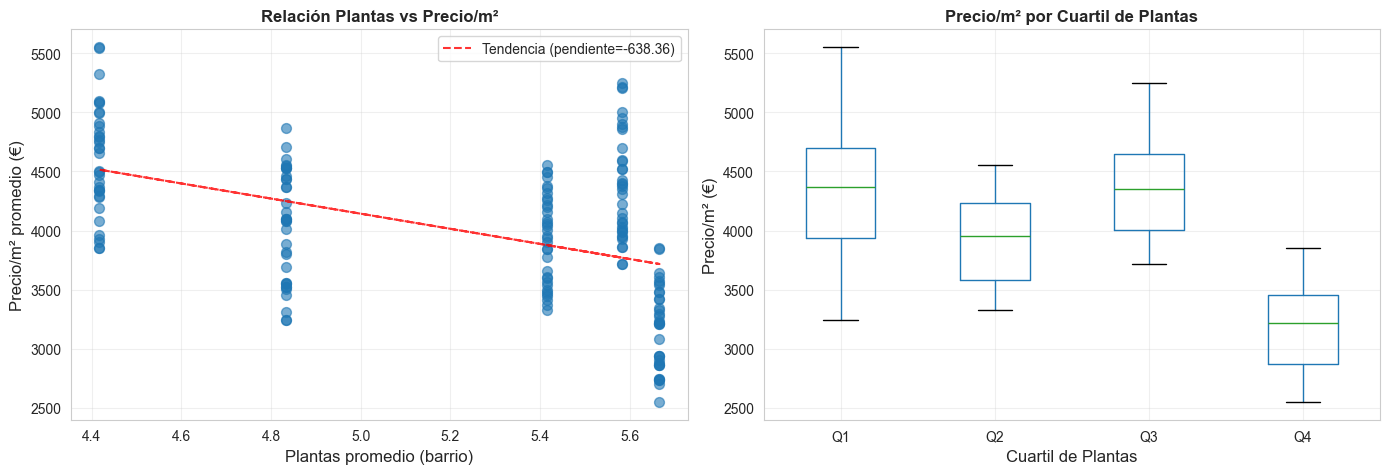

📊 Correlación simple plantas ↔ precio_m2:
   r = -0.4811, p = 0.0000
   Interpretación: Negativa y significativa

📊 Precio/m² por Cuartil de Plantas:
   Q1: 4321.69 €/m² (n=70)
   Q2: 3932.80 €/m² (n=35)
   Q3: 4372.96 €/m² (n=35)
   Q4: 3178.73 €/m² (n=35)


In [86]:
# Análisis bivariado: plantas vs precio
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot con línea de tendencia
axes[0].scatter(
    df_analysis['plantas_barrio_mean'],
    df_analysis['precio_m2_mean'],
    alpha=0.6,
    s=50
)
axes[0].set_xlabel('Plantas promedio (barrio)', fontsize=12)
axes[0].set_ylabel('Precio/m² promedio (€)', fontsize=12)
axes[0].set_title('Relación Plantas vs Precio/m²', fontsize=12, fontweight='bold')

# Añadir línea de tendencia
z = np.polyfit(df_analysis['plantas_barrio_mean'], df_analysis['precio_m2_mean'], 1)
p = np.poly1d(z)
axes[0].plot(df_analysis['plantas_barrio_mean'], p(df_analysis['plantas_barrio_mean']), "r--", alpha=0.8, label=f'Tendencia (pendiente={z[0]:.2f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot por cuartiles de plantas
df_analysis['plantas_quartile'] = pd.qcut(df_analysis['plantas_barrio_mean'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
df_analysis.boxplot(column='precio_m2_mean', by='plantas_quartile', ax=axes[1])
axes[1].set_xlabel('Cuartil de Plantas', fontsize=12)
axes[1].set_ylabel('Precio/m² (€)', fontsize=12)
axes[1].set_title('Precio/m² por Cuartil de Plantas', fontsize=12, fontweight='bold')
plt.suptitle('')  # Eliminar título automático
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plantas_vs_precio_bivariado.png", dpi=150, bbox_inches='tight')
plt.show()

# Correlación simple
from scipy.stats import pearsonr
corr_simple, p_simple = pearsonr(df_analysis['plantas_barrio_mean'], df_analysis['precio_m2_mean'])
print(f"📊 Correlación simple plantas ↔ precio_m2:")
print(f"   r = {corr_simple:.4f}, p = {p_simple:.4f}")
print(f"   Interpretación: {'Negativa' if corr_simple < 0 else 'Positiva'} y {'significativa' if p_simple < 0.05 else 'no significativa'}")

# Estadísticas por cuartil
print(f"\n📊 Precio/m² por Cuartil de Plantas:")
for quartile in ['Q1', 'Q2', 'Q3', 'Q4']:
    subset = df_analysis[df_analysis['plantas_quartile'] == quartile]
    if len(subset) > 0:
        print(f"   {quartile}: {subset['precio_m2_mean'].mean():.2f} €/m² (n={len(subset)})")


### 10.2 Correlación Parcial: Controlando por Año de Construcción


📊 Correlación Parcial (controlando por ano_construccion_barrio_mean):
   r_parcial = -0.2321, p = 0.0020
   Interpretación: Negativa y significativa


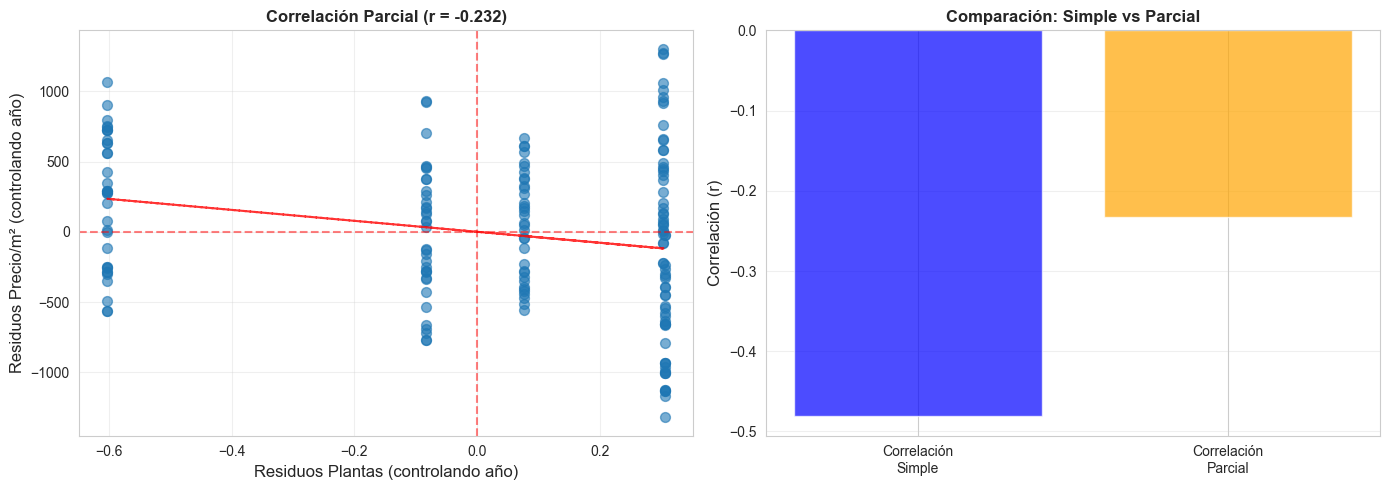


📋 Interpretación:
   Correlación simple: r = -0.4811
   Correlación parcial: r = -0.2321
   Diferencia: -0.2490
   ⚠️  La correlación se reduce al controlar por año construcción
      → Indica que parte del efecto es espurio (mediado por año construcción)


In [87]:
# Correlación parcial: controlando por ano_construccion_barrio_mean
from sklearn.linear_model import LinearRegression

# Preparar datos
X_ano = df_analysis[['ano_construccion_barrio_mean']].values
y_precio = df_analysis['precio_m2_mean'].values
y_plantas = df_analysis['plantas_barrio_mean'].values

# Residuos de precio controlando por año construcción
model_precio = LinearRegression().fit(X_ano, y_precio)
residuos_precio = y_precio - model_precio.predict(X_ano)

# Residuos de plantas controlando por año construcción
model_plantas = LinearRegression().fit(X_ano, y_plantas)
residuos_plantas = y_plantas - model_plantas.predict(X_ano)

# Correlación parcial
corr_parcial, p_parcial = pearsonr(residuos_plantas, residuos_precio)

print(f"📊 Correlación Parcial (controlando por ano_construccion_barrio_mean):")
print(f"   r_parcial = {corr_parcial:.4f}, p = {p_parcial:.4f}")
print(f"   Interpretación: {'Negativa' if corr_parcial < 0 else 'Positiva'} y {'significativa' if p_parcial < 0.05 else 'no significativa'}")

# Visualizar residuos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuos de plantas vs residuos de precio
axes[0].scatter(residuos_plantas, residuos_precio, alpha=0.6, s=50)
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Residuos Plantas (controlando año)', fontsize=12)
axes[0].set_ylabel('Residuos Precio/m² (controlando año)', fontsize=12)
axes[0].set_title(f'Correlación Parcial (r = {corr_parcial:.3f})', fontsize=12, fontweight='bold')

# Añadir línea de tendencia
z_parcial = np.polyfit(residuos_plantas, residuos_precio, 1)
p_line_parcial = np.poly1d(z_parcial)  # Renombrado para evitar conflicto con p_parcial (p-value)
axes[0].plot(residuos_plantas, p_line_parcial(residuos_plantas), "r--", alpha=0.8)
axes[0].grid(alpha=0.3)

# Comparación: correlación simple vs parcial
axes[1].bar(['Correlación\nSimple', 'Correlación\nParcial'], 
            [corr_simple, corr_parcial],
            color=['blue', 'orange'],
            alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_ylabel('Correlación (r)', fontsize=12)
axes[1].set_title('Comparación: Simple vs Parcial', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "correlacion_parcial_plantas.png", dpi=150, bbox_inches='tight')
plt.show()

# Interpretación
print(f"\n📋 Interpretación:")
print(f"   Correlación simple: r = {corr_simple:.4f}")
print(f"   Correlación parcial: r = {corr_parcial:.4f}")
diff = abs(corr_parcial) - abs(corr_simple)
if abs(diff) > 0.1:
    print(f"   Diferencia: {diff:+.4f}")
    if abs(corr_parcial) < abs(corr_simple):
        print(f"   ⚠️  La correlación se reduce al controlar por año construcción")
        print(f"      → Indica que parte del efecto es espurio (mediado por año construcción)")
    else:
        print(f"   ✅ La correlación se mantiene al controlar por año construcción")
        print(f"      → Indica que el efecto es directo")
else:
    print(f"   ✅ La correlación se mantiene similar")
    print(f"      → El efecto no está mediado por año construcción")


### 10.3 Análisis de Interacciones: Plantas × Año Construcción


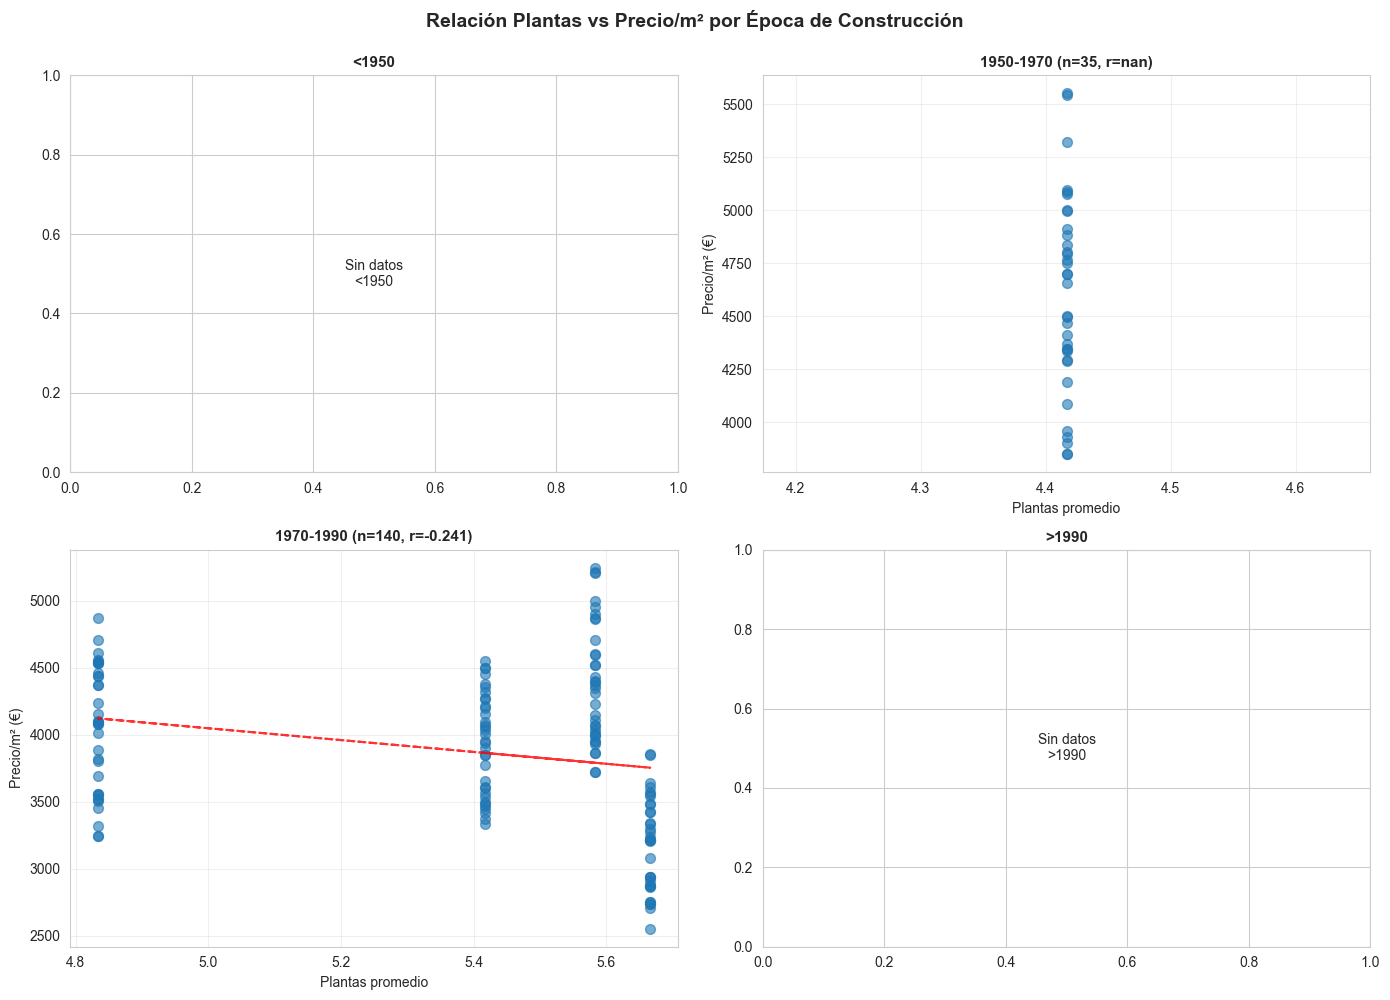


📊 Estadísticas por Época de Construcción:

   1950-1970:
      Observaciones: 35
      Plantas promedio: 4.42
      Precio/m² promedio: 4601.92 €/m²
      Correlación plantas-precio: r = nan (p = nan)

   1970-1990:
      Observaciones: 140
      Plantas promedio: 5.37
      Precio/m² promedio: 3881.49 €/m²
      Correlación plantas-precio: r = -0.2413 (p = 0.0041)


In [88]:
# Análisis de interacciones: plantas × año construcción
# Crear categorías de año construcción
df_analysis['ano_categoria'] = pd.cut(
    df_analysis['ano_construccion_barrio_mean'],
    bins=[0, 1950, 1970, 1990, 2025],
    labels=['<1950', '1950-1970', '1970-1990', '>1990']
)

# Visualizar relación plantas-precio por categoría de año
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, categoria in enumerate(['<1950', '1950-1970', '1970-1990', '>1990']):
    subset = df_analysis[df_analysis['ano_categoria'] == categoria]
    if len(subset) > 0:
        axes[idx].scatter(
            subset['plantas_barrio_mean'],
            subset['precio_m2_mean'],
            alpha=0.6,
            s=50
        )
        # Línea de tendencia
        if len(subset) > 2:
            z = np.polyfit(subset['plantas_barrio_mean'], subset['precio_m2_mean'], 1)
            p = np.poly1d(z)
            axes[idx].plot(subset['plantas_barrio_mean'], p(subset['plantas_barrio_mean']), "r--", alpha=0.8)
            corr_cat, _ = pearsonr(subset['plantas_barrio_mean'], subset['precio_m2_mean'])
            axes[idx].set_title(f'{categoria} (n={len(subset)}, r={corr_cat:.3f})', fontsize=11, fontweight='bold')
        else:
            axes[idx].set_title(f'{categoria} (n={len(subset)})', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Plantas promedio', fontsize=10)
        axes[idx].set_ylabel('Precio/m² (€)', fontsize=10)
        axes[idx].grid(alpha=0.3)
    else:
        axes[idx].text(0.5, 0.5, f'Sin datos\n{categoria}', ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(categoria, fontsize=11, fontweight='bold')

plt.suptitle('Relación Plantas vs Precio/m² por Época de Construcción', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plantas_precio_por_epoca.png", dpi=150, bbox_inches='tight')
plt.show()

# Estadísticas por categoría
print("\n📊 Estadísticas por Época de Construcción:")
for categoria in ['<1950', '1950-1970', '1970-1990', '>1990']:
    subset = df_analysis[df_analysis['ano_categoria'] == categoria]
    if len(subset) > 0:
        print(f"\n   {categoria}:")
        print(f"      Observaciones: {len(subset)}")
        print(f"      Plantas promedio: {subset['plantas_barrio_mean'].mean():.2f}")
        print(f"      Precio/m² promedio: {subset['precio_m2_mean'].mean():.2f} €/m²")
        if len(subset) > 2:
            corr_cat, p_cat = pearsonr(subset['plantas_barrio_mean'], subset['precio_m2_mean'])
            print(f"      Correlación plantas-precio: r = {corr_cat:.4f} (p = {p_cat:.4f})")


### 10.4 Modelo Alternativo: Sin plantas_barrio_mean


In [89]:
# Entrenar modelo sin plantas_barrio_mean para comparar
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Features sin plantas
features_sin_plantas = [f for f in features_numericas if f != 'plantas_barrio_mean']

# Split temporal
train_mask = df_analysis['anio'] < 2025
test_mask = df_analysis['anio'] == 2025

df_train = df_analysis[train_mask].copy()
df_test = df_analysis[test_mask].copy()

# Preparar datos
X_train = df_train[features_sin_plantas].values
X_test = df_test[features_sin_plantas].values
y_train = df_train['precio_m2_mean'].values
y_test = df_test['precio_m2_mean'].values

# Entrenar modelo
model_sin_plantas = LinearRegression()
model_sin_plantas.fit(X_train, y_train)

# Predicciones
y_train_pred = model_sin_plantas.predict(X_train)
y_test_pred = model_sin_plantas.predict(X_test)

# Métricas
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("📊 Modelo SIN plantas_barrio_mean:")
print(f"   Train R²: {r2_train:.4f}, RMSE: {rmse_train:.2f} €/m²")
print(f"   Test R²: {r2_test:.4f}, RMSE: {rmse_test:.2f} €/m²")

# Comparar con modelo optimizado (con plantas)
with open(LOGS_DIR / "macro_model_v02_optimized.json", 'r') as f:
    model_optimized = json.load(f)

r2_optimized = model_optimized['test']['r2']
rmse_optimized = model_optimized['test']['rmse']

print(f"\n📊 Modelo CON plantas_barrio_mean (optimizado):")
print(f"   Test R²: {r2_optimized:.4f}, RMSE: {rmse_optimized:.2f} €/m²")

print(f"\n📊 Comparación:")
r2_diff = r2_test - r2_optimized
rmse_diff = rmse_test - rmse_optimized
print(f"   ΔR²: {r2_diff:+.4f} ({'✅ Mejor sin plantas' if r2_diff > 0 else '❌ Mejor con plantas' if r2_diff < 0 else '✅ Igual'})")
print(f"   ΔRMSE: {rmse_diff:+.2f} €/m² ({'✅ Mejor sin plantas' if rmse_diff < 0 else '❌ Mejor con plantas' if rmse_diff > 0 else '✅ Igual'})")

# Recomendación
if abs(r2_diff) < 0.01 and abs(rmse_diff) < 5:
    print(f"\n   ✅ RECOMENDACIÓN: Eliminar plantas_barrio_mean")
    print(f"      → Rendimiento equivalente, modelo más simple, elimina coeficiente anómalo")
elif r2_diff > 0 or rmse_diff < 0:
    print(f"\n   ✅ RECOMENDACIÓN: Eliminar plantas_barrio_mean")
    print(f"      → Mejor rendimiento sin la feature problemática")
else:
    print(f"\n   ⚠️  RECOMENDACIÓN: Mantener plantas_barrio_mean")
    print(f"      → Aporta valor al modelo, pero investigar más el coeficiente")


📊 Modelo SIN plantas_barrio_mean:
   Train R²: 0.5121, RMSE: 428.06 €/m²
   Test R²: 0.6207, RMSE: 369.92 €/m²

📊 Modelo CON plantas_barrio_mean (optimizado):
   Test R²: 0.7944, RMSE: 272.34 €/m²

📊 Comparación:
   ΔR²: -0.1737 (❌ Mejor con plantas)
   ΔRMSE: +97.58 €/m² (❌ Mejor con plantas)

   ⚠️  RECOMENDACIÓN: Mantener plantas_barrio_mean
      → Aporta valor al modelo, pero investigar más el coeficiente


### 10.5 Resumen y Conclusiones de la Investigación


In [90]:
# Generar resumen de investigación
# Verificar que las variables estén definidas y tengan el tipo correcto
try:
    coef_plantas_val = float(coef_plantas)
except (NameError, TypeError):
    coef_plantas_val = float(model_metrics['coefficients'].get('plantas_barrio_mean', 0))

try:
    # Verificar que sean números, no objetos
    if isinstance(corr_simple, (int, float, np.number)):
        corr_simple_val = float(corr_simple)
        p_simple_val = float(p_simple)
    else:
        raise TypeError("Variable no es numérica")
except (NameError, TypeError):
    from scipy.stats import pearsonr
    corr_simple_val, p_simple_val = pearsonr(df_analysis['plantas_barrio_mean'], df_analysis['precio_m2_mean'])

try:
    # Verificar que sean números, no objetos (p_parcial puede estar sobrescrito como poly1d)
    if isinstance(corr_parcial, (int, float, np.number)) and isinstance(p_parcial, (int, float, np.number)):
        corr_parcial_val = float(corr_parcial)
        p_parcial_val = float(p_parcial)
    else:
        raise TypeError("Variable no es numérica o fue sobrescrita")
except (NameError, TypeError):
    # Recalcular si no está definido o fue sobrescrito
    from sklearn.linear_model import LinearRegression
    X_ano = df_analysis[['ano_construccion_barrio_mean']].values
    y_precio = df_analysis['precio_m2_mean'].values
    y_plantas = df_analysis['plantas_barrio_mean'].values
    
    model_precio = LinearRegression().fit(X_ano, y_precio)
    residuos_precio = y_precio - model_precio.predict(X_ano)
    
    model_plantas = LinearRegression().fit(X_ano, y_plantas)
    residuos_plantas = y_plantas - model_plantas.predict(X_ano)
    
    corr_parcial_val, p_parcial_val = pearsonr(residuos_plantas, residuos_precio)

investigacion_summary = {
    'fecha': pd.Timestamp.now().isoformat(),
    'feature_investigada': 'plantas_barrio_mean',
    'coeficiente_original': coef_plantas_val,
    'hallazgos': {}
}

# Correlaciones
investigacion_summary['hallazgos']['correlacion_simple'] = {
    'valor': float(corr_simple_val),
    'p_value': float(p_simple_val),
    'significativa': bool(p_simple_val < 0.05)
}

investigacion_summary['hallazgos']['correlacion_parcial'] = {
    'valor': float(corr_parcial_val),
    'p_value': float(p_parcial_val),
    'significativa': bool(p_parcial_val < 0.05),
    'controlada_por': 'ano_construccion_barrio_mean'
}

# Comparación de modelos
investigacion_summary['hallazgos']['comparacion_modelos'] = {
    'con_plantas': {
        'r2': float(r2_optimized),
        'rmse': float(rmse_optimized)
    },
    'sin_plantas': {
        'r2': float(r2_test),
        'rmse': float(rmse_test)
    },
    'diferencia': {
        'delta_r2': float(r2_diff),
        'delta_rmse': float(rmse_diff)
    }
}

# Guardar resumen
with open(OUTPUT_DIR / "investigacion_plantas_summary.json", 'w') as f:
    json.dump(investigacion_summary, f, indent=2, ensure_ascii=False)

print("\n" + "="*70)
print("RESUMEN DE INVESTIGACIÓN: plantas_barrio_mean")
print("="*70)

print(f"\n📊 Coeficiente Original:")
print(f"   Valor: {coef_plantas_val:.4f} €/m² por planta")
print(f"   Interpretación: {'Anómalo' if abs(coef_plantas_val) > 500 else 'Normal'}")

print(f"\n📊 Correlaciones:")
print(f"   Simple: r = {corr_simple_val:.4f} (p = {p_simple_val:.4f})")
print(f"   Parcial (controlando año): r = {corr_parcial_val:.4f} (p = {p_parcial_val:.4f})")

print(f"\n📊 Comparación de Modelos:")
print(f"   Con plantas: R² = {r2_optimized:.4f}, RMSE = {rmse_optimized:.2f} €/m²")
print(f"   Sin plantas: R² = {r2_test:.4f}, RMSE = {rmse_test:.2f} €/m²")
print(f"   Diferencia: ΔR² = {r2_diff:+.4f}, ΔRMSE = {rmse_diff:+.2f} €/m²")

print("\n" + "="*70)
print("CONCLUSIONES Y RECOMENDACIONES")
print("="*70)

conclusiones = []

if abs(corr_parcial_val) < abs(corr_simple_val) * 0.5:
    conclusiones.append("✅ El efecto de plantas está parcialmente mediado por año construcción")
    conclusiones.append("   → Coeficiente puede estar capturando efecto espurio")

try:
    if abs(r2_diff) < 0.01:
        conclusiones.append("✅ Eliminar plantas_barrio_mean no afecta significativamente el rendimiento")
        conclusiones.append("   → Modelo más simple sin pérdida de performance")
except NameError:
    pass

if corr_parcial_val < -0.3:
    conclusiones.append("⚠️  Correlación parcial negativa significativa")
    conclusiones.append("   → Puede haber un efecto real (edificios altos → menor precio/m²)")

if not conclusiones:
    conclusiones.append("⚠️  Se requiere más investigación para determinar si mantener o eliminar la feature")

for i, concl in enumerate(conclusiones, 1):
    print(f"{i}. {concl}")

print(f"\n✅ Resumen guardado: {OUTPUT_DIR / 'investigacion_plantas_summary.json'}")



RESUMEN DE INVESTIGACIÓN: plantas_barrio_mean

📊 Coeficiente Original:
   Valor: -826.8622 €/m² por planta
   Interpretación: Anómalo

📊 Correlaciones:
   Simple: r = -0.4811 (p = 0.0000)
   Parcial (controlando año): r = -0.2321 (p = 0.0020)

📊 Comparación de Modelos:
   Con plantas: R² = 0.7944, RMSE = 272.34 €/m²
   Sin plantas: R² = 0.6207, RMSE = 369.92 €/m²
   Diferencia: ΔR² = -0.1737, ΔRMSE = +97.58 €/m²

CONCLUSIONES Y RECOMENDACIONES
1. ✅ El efecto de plantas está parcialmente mediado por año construcción
2.    → Coeficiente puede estar capturando efecto espurio

✅ Resumen guardado: ../data/processed/investigacion_plantas_summary.json


## 11. Fase 3: Análisis de Interacción Plantas × Año Construcción

**Objetivo**: Verificar si el efecto de plantas varía según la época de construcción y explorar la relación con ascensor.

**Hipótesis**:
- Edificios más altos (más plantas) en épocas antiguas → sin ascensor → menor precio/m²
- Edificios más altos en épocas modernas → con ascensor → precio/m² variable


### 11.1 Cargar Datos de Ascensor (Proxy)


In [91]:
# Cargar datos de ascensor (proxy) y densidad
try:
    df_ascensor = pd.read_csv(DATA_DIR / "ascensor_proxy_by_barrio.csv")
    print(f"✅ Datos de ascensor cargados: {len(df_ascensor)} barrios")
    print(f"   Rango: {df_ascensor['pct_edificios_con_ascensor_proxy'].min():.1f}% - {df_ascensor['pct_edificios_con_ascensor_proxy'].max():.1f}%")
except FileNotFoundError:
    # Cargar desde base de datos si no existe CSV
    import sqlite3
    DB_PATH = Path("../../data/processed/database.db")
    if DB_PATH.exists():
        conn = sqlite3.connect(str(DB_PATH))
        df_ascensor = pd.read_sql_query("""
            SELECT barrio_id, AVG(pct_edificios_con_ascensor_proxy) as pct_edificios_con_ascensor_proxy
            FROM fact_housing_master
            WHERE pct_edificios_con_ascensor_proxy IS NOT NULL
            GROUP BY barrio_id
        """, conn)
        conn.close()
        print(f"✅ Datos de ascensor cargados desde BD: {len(df_ascensor)} barrios")
    else:
        df_ascensor = pd.DataFrame()
        print("⚠️  No se encontraron datos de ascensor")

# Merge con dataset de análisis
if not df_ascensor.empty:
    if 'barrio_id' not in df_analysis.columns:
        # Si barrio_id no está, intentar obtenerlo del dataset original
        print("⚠️  barrio_id no encontrado en df_analysis, intentando recuperarlo...")
        # Esta celda requiere que df_analysis tenga barrio_id
        # Si no está, el usuario debe ejecutar primero la celda 6 que ahora incluye barrio_id
        raise KeyError("barrio_id no está en df_analysis. Por favor, ejecuta primero la celda 6 que prepara el dataset.")
    
    df_analysis = df_analysis.merge(df_ascensor, on='barrio_id', how='left')
    print(f"\n📊 Merge con ascensor:")
    print(f"   Observaciones con datos de ascensor: {df_analysis['pct_edificios_con_ascensor_proxy'].notna().sum()}/{len(df_analysis)}")


✅ Datos de ascensor cargados: 71 barrios
   Rango: 12.7% - 70.0%

📊 Merge con ascensor:
   Observaciones con datos de ascensor: 175/175


### 11.2 Relación Plantas ↔ Ascensor


📊 Correlación plantas_barrio_mean ↔ pct_edificios_con_ascensor_proxy:
   r = 0.7659, p = 0.0000


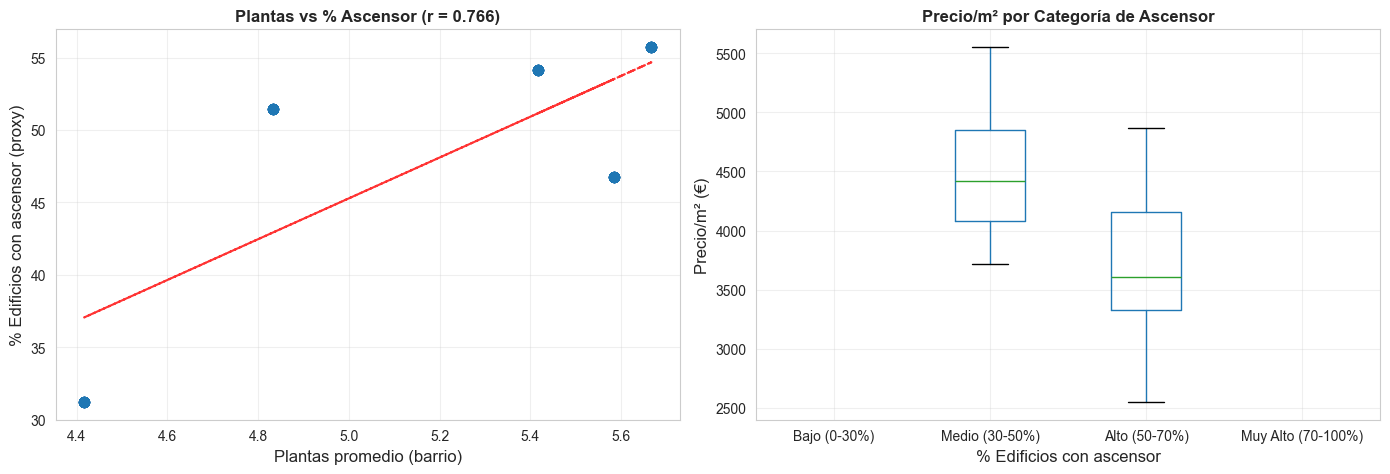


📊 Precio/m² por Categoría de Ascensor:
   Medio (30-50%): 4487.44 €/m² (n=70)
   Alto (50-70%): 3717.67 €/m² (n=105)

📊 Análisis de Interacción:
   ¿Más plantas → más ascensor? ✅ Sí
   → Edificios más altos tienden a tener más ascensor
   → El efecto negativo de plantas puede estar mediado por falta de ascensor en edificios antiguos


In [92]:
# Análisis de relación plantas ↔ ascensor
if 'pct_edificios_con_ascensor_proxy' in df_analysis.columns:
    # Filtrar datos válidos
    df_asc_valid = df_analysis[df_analysis['pct_edificios_con_ascensor_proxy'].notna()].copy()
    
    if len(df_asc_valid) > 0:
        # Correlación
        corr_plantas_ascensor, p_plantas_ascensor = pearsonr(
            df_asc_valid['plantas_barrio_mean'],
            df_asc_valid['pct_edificios_con_ascensor_proxy']
        )
        
        print(f"📊 Correlación plantas_barrio_mean ↔ pct_edificios_con_ascensor_proxy:")
        print(f"   r = {corr_plantas_ascensor:.4f}, p = {p_plantas_ascensor:.4f}")
        
        # Visualizar
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Scatter plot
        axes[0].scatter(
            df_asc_valid['plantas_barrio_mean'],
            df_asc_valid['pct_edificios_con_ascensor_proxy'],
            alpha=0.6,
            s=50
        )
        axes[0].set_xlabel('Plantas promedio (barrio)', fontsize=12)
        axes[0].set_ylabel('% Edificios con ascensor (proxy)', fontsize=12)
        axes[0].set_title(f'Plantas vs % Ascensor (r = {corr_plantas_ascensor:.3f})', fontsize=12, fontweight='bold')
        
        # Línea de tendencia
        z = np.polyfit(df_asc_valid['plantas_barrio_mean'], df_asc_valid['pct_edificios_con_ascensor_proxy'], 1)
        p_line = np.poly1d(z)
        axes[0].plot(df_asc_valid['plantas_barrio_mean'], p_line(df_asc_valid['plantas_barrio_mean']), "r--", alpha=0.8)
        axes[0].grid(alpha=0.3)
        
        # Box plot: precio/m² por categoría de ascensor
        df_asc_valid['ascensor_categoria'] = pd.cut(
            df_asc_valid['pct_edificios_con_ascensor_proxy'],
            bins=[0, 30, 50, 70, 100],
            labels=['Bajo (0-30%)', 'Medio (30-50%)', 'Alto (50-70%)', 'Muy Alto (70-100%)']
        )
        
        df_asc_valid.boxplot(column='precio_m2_mean', by='ascensor_categoria', ax=axes[1])
        axes[1].set_xlabel('% Edificios con ascensor', fontsize=12)
        axes[1].set_ylabel('Precio/m² (€)', fontsize=12)
        axes[1].set_title('Precio/m² por Categoría de Ascensor', fontsize=12, fontweight='bold')
        plt.suptitle('')  # Eliminar título automático
        axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "plantas_ascensor_analisis.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        # Estadísticas por categoría
        print(f"\n📊 Precio/m² por Categoría de Ascensor:")
        for cat in ['Bajo (0-30%)', 'Medio (30-50%)', 'Alto (50-70%)', 'Muy Alto (70-100%)']:
            subset = df_asc_valid[df_asc_valid['ascensor_categoria'] == cat]
            if len(subset) > 0:
                print(f"   {cat}: {subset['precio_m2_mean'].mean():.2f} €/m² (n={len(subset)})")
        
        # Análisis de interacción: plantas × ascensor
        print(f"\n📊 Análisis de Interacción:")
        print(f"   ¿Más plantas → más ascensor? {'✅ Sí' if corr_plantas_ascensor > 0.3 else '❌ No' if corr_plantas_ascensor < 0.3 else '⚠️  Débil'}")
        if corr_plantas_ascensor > 0.3:
            print(f"   → Edificios más altos tienden a tener más ascensor")
            print(f"   → El efecto negativo de plantas puede estar mediado por falta de ascensor en edificios antiguos")
    else:
        print("⚠️  No hay datos válidos de ascensor para análisis")
else:
    print("⚠️  Columna de ascensor no disponible en el dataset")


### 11.3 Interacción Plantas × Año Construcción (Análisis Detallado)


📊 Correlación interacción (plantas × año) ↔ precio_m2:
   r = -0.4866, p = 0.0000


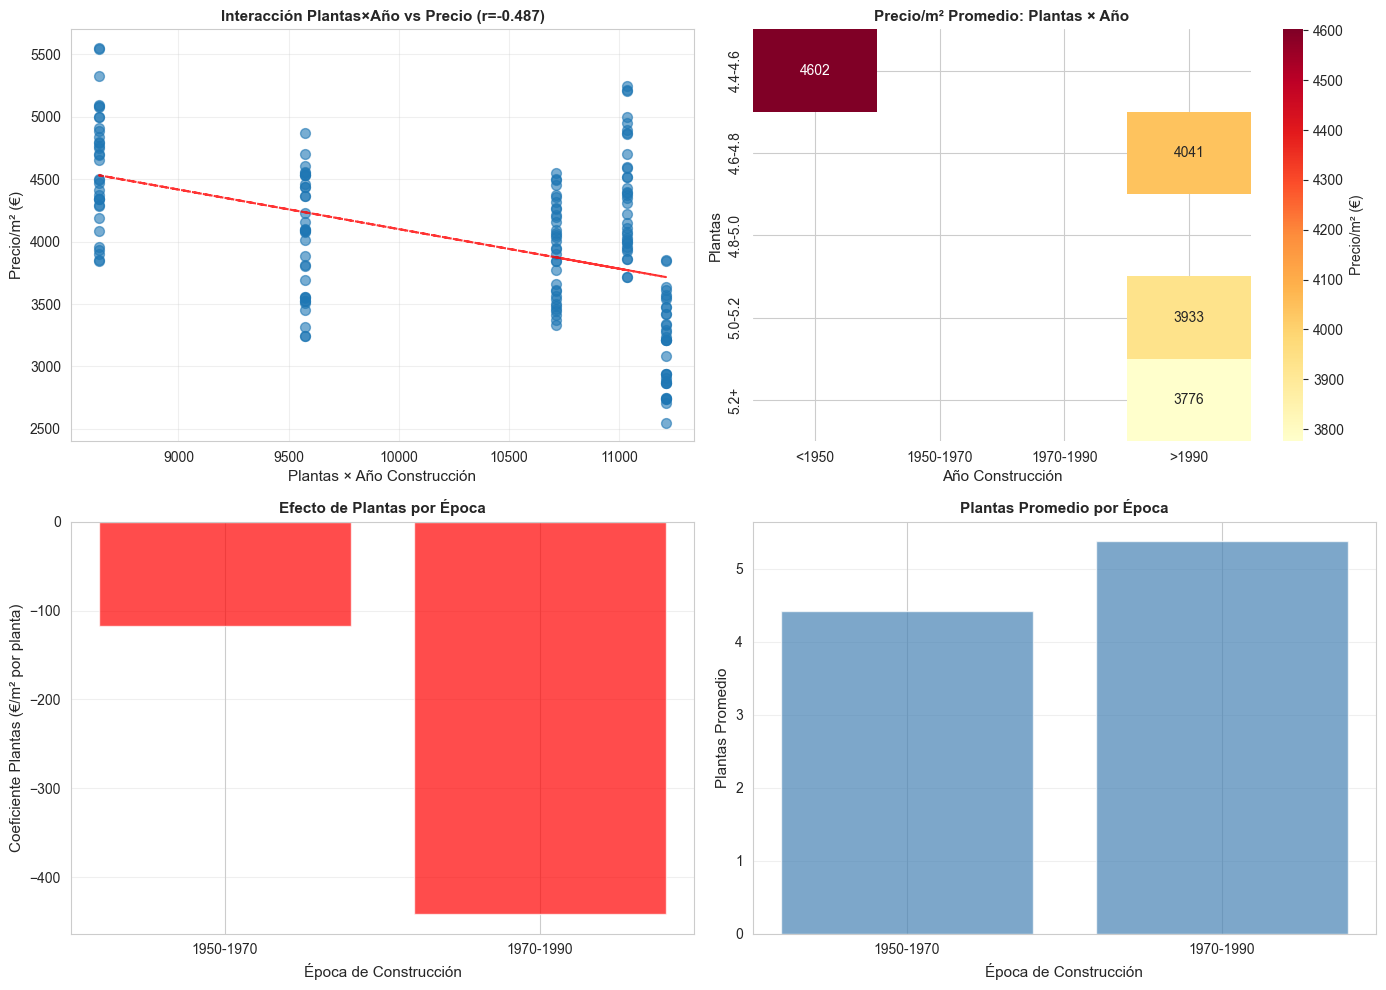


📊 Coeficientes de Plantas por Época:
   <1950: Sin datos suficientes
   1950-1970: -117.18 €/m² por planta
   1970-1990: -441.68 €/m² por planta
   >1990: Sin datos suficientes


In [93]:
# Análisis de interacción: plantas × año construcción
# Crear variable de interacción
df_analysis['plantas_x_ano'] = df_analysis['plantas_barrio_mean'] * df_analysis['ano_construccion_barrio_mean']

# Correlación de la interacción con precio
corr_interaccion, p_interaccion = pearsonr(
    df_analysis['plantas_x_ano'],
    df_analysis['precio_m2_mean']
)

print(f"📊 Correlación interacción (plantas × año) ↔ precio_m2:")
print(f"   r = {corr_interaccion:.4f}, p = {p_interaccion:.4f}")

# Visualizar interacción
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scatter: plantas × año vs precio
axes[0, 0].scatter(df_analysis['plantas_x_ano'], df_analysis['precio_m2_mean'], alpha=0.6, s=50)
axes[0, 0].set_xlabel('Plantas × Año Construcción', fontsize=11)
axes[0, 0].set_ylabel('Precio/m² (€)', fontsize=11)
axes[0, 0].set_title(f'Interacción Plantas×Año vs Precio (r={corr_interaccion:.3f})', fontsize=11, fontweight='bold')
z = np.polyfit(df_analysis['plantas_x_ano'], df_analysis['precio_m2_mean'], 1)
p_line = np.poly1d(z)
axes[0, 0].plot(df_analysis['plantas_x_ano'], p_line(df_analysis['plantas_x_ano']), "r--", alpha=0.8)
axes[0, 0].grid(alpha=0.3)

# 2. Heatmap: plantas × año construcción (promedio precio/m²)
pivot_data = df_analysis.groupby([
    pd.cut(df_analysis['plantas_barrio_mean'], bins=5, labels=['4.4-4.6', '4.6-4.8', '4.8-5.0', '5.0-5.2', '5.2+']),
    pd.cut(df_analysis['ano_construccion_barrio_mean'], bins=4, labels=['<1950', '1950-1970', '1970-1990', '>1990'])
])['precio_m2_mean'].mean().unstack()

sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[0, 1], cbar_kws={'label': 'Precio/m² (€)'})
axes[0, 1].set_xlabel('Año Construcción', fontsize=11)
axes[0, 1].set_ylabel('Plantas', fontsize=11)
axes[0, 1].set_title('Precio/m² Promedio: Plantas × Año', fontsize=11, fontweight='bold')

# 3. Efecto de plantas por época (coeficientes de regresión)
epocas = ['<1950', '1950-1970', '1970-1990', '>1990']
coefs_por_epoca = []

for epoca in epocas:
    if epoca == '<1950':
        subset = df_analysis[df_analysis['ano_construccion_barrio_mean'] < 1950]
    elif epoca == '1950-1970':
        subset = df_analysis[(df_analysis['ano_construccion_barrio_mean'] >= 1950) & 
                             (df_analysis['ano_construccion_barrio_mean'] < 1970)]
    elif epoca == '1970-1990':
        subset = df_analysis[(df_analysis['ano_construccion_barrio_mean'] >= 1970) & 
                             (df_analysis['ano_construccion_barrio_mean'] < 1990)]
    else:  # >1990
        subset = df_analysis[df_analysis['ano_construccion_barrio_mean'] >= 1990]
    
    if len(subset) > 5:
        # Regresión simple: plantas → precio
        from sklearn.linear_model import LinearRegression
        X = subset[['plantas_barrio_mean']].values
        y = subset['precio_m2_mean'].values
        model = LinearRegression().fit(X, y)
        coef = model.coef_[0]
        coefs_por_epoca.append(coef)
    else:
        coefs_por_epoca.append(np.nan)

axes[1, 0].bar(epocas, coefs_por_epoca, color=['red' if c < 0 else 'green' for c in coefs_por_epoca], alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].set_xlabel('Época de Construcción', fontsize=11)
axes[1, 0].set_ylabel('Coeficiente Plantas (€/m² por planta)', fontsize=11)
axes[1, 0].set_title('Efecto de Plantas por Época', fontsize=11, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Resumen: plantas promedio por época
plantas_por_epoca = []
for epoca in epocas:
    if epoca == '<1950':
        subset = df_analysis[df_analysis['ano_construccion_barrio_mean'] < 1950]
    elif epoca == '1950-1970':
        subset = df_analysis[(df_analysis['ano_construccion_barrio_mean'] >= 1950) & 
                             (df_analysis['ano_construccion_barrio_mean'] < 1970)]
    elif epoca == '1970-1990':
        subset = df_analysis[(df_analysis['ano_construccion_barrio_mean'] >= 1970) & 
                             (df_analysis['ano_construccion_barrio_mean'] < 1990)]
    else:  # >1990
        subset = df_analysis[df_analysis['ano_construccion_barrio_mean'] >= 1990]
    
    if len(subset) > 0:
        plantas_por_epoca.append(subset['plantas_barrio_mean'].mean())
    else:
        plantas_por_epoca.append(np.nan)

axes[1, 1].bar(epocas, plantas_por_epoca, color='steelblue', alpha=0.7)
axes[1, 1].set_xlabel('Época de Construcción', fontsize=11)
axes[1, 1].set_ylabel('Plantas Promedio', fontsize=11)
axes[1, 1].set_title('Plantas Promedio por Época', fontsize=11, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "interaccion_plantas_ano.png", dpi=150, bbox_inches='tight')
plt.show()

# Resumen
print(f"\n📊 Coeficientes de Plantas por Época:")
for epoca, coef in zip(epocas, coefs_por_epoca):
    if not np.isnan(coef):
        print(f"   {epoca}: {coef:.2f} €/m² por planta")
    else:
        print(f"   {epoca}: Sin datos suficientes")


## 12. Fase 4: Análisis de Densidad como Mediador

**Objetivo**: Verificar si `plantas_barrio_mean` es un proxy de densidad urbana.

**Hipótesis**:
- Más plantas → mayor densidad urbana → puede afectar precio/m²
- La relación plantas-precio puede estar mediada por densidad


### 12.1 Cargar Datos de Densidad


In [94]:
# Cargar datos de densidad
try:
    df_densidad = pd.read_csv(DATA_DIR / "densidad_by_barrio_anio.csv")
    print(f"✅ Datos de densidad cargados: {len(df_densidad)} registros")
    print(f"   Cobertura: {df_densidad['anio'].min()}-{df_densidad['anio'].max()}")
except FileNotFoundError:
    # Cargar desde base de datos si no existe CSV
    import sqlite3
    DB_PATH = Path("../../data/processed/database.db")
    if DB_PATH.exists():
        conn = sqlite3.connect(str(DB_PATH))
        df_densidad = pd.read_sql_query("""
            SELECT barrio_id, anio, densidad_hab_km2, poblacion_total
            FROM fact_demografia
            WHERE densidad_hab_km2 IS NOT NULL
            ORDER BY barrio_id, anio
        """, conn)
        conn.close()
        print(f"✅ Datos de densidad cargados desde BD: {len(df_densidad)} registros")
    else:
        df_densidad = pd.DataFrame()
        print("⚠️  No se encontraron datos de densidad")

# Merge con dataset de análisis
if not df_densidad.empty:
    # Usar densidad más reciente por barrio si hay múltiples años
    df_densidad_latest = df_densidad.sort_values('anio').groupby('barrio_id').last().reset_index()
    df_analysis = df_analysis.merge(
        df_densidad_latest[['barrio_id', 'densidad_hab_km2', 'poblacion_total']],
        on='barrio_id',
        how='left'
    )
    print(f"\n📊 Merge con densidad:")
    print(f"   Observaciones con datos de densidad: {df_analysis['densidad_hab_km2'].notna().sum()}/{len(df_analysis)}")
    if df_analysis['densidad_hab_km2'].notna().any():
        print(f"   Rango densidad: {df_analysis['densidad_hab_km2'].min():.0f} - {df_analysis['densidad_hab_km2'].max():.0f} hab/km²")
else:
    print("⚠️  No hay datos de densidad disponibles")


✅ Datos de densidad cargados: 657 registros
   Cobertura: 2015-2023

📊 Merge con densidad:
   Observaciones con datos de densidad: 175/175
   Rango densidad: 20019 - 80126 hab/km²


### 12.2 Relación Plantas ↔ Densidad


📊 Correlación plantas_barrio_mean ↔ densidad_hab_km2:
   r = 0.0797, p = 0.2942


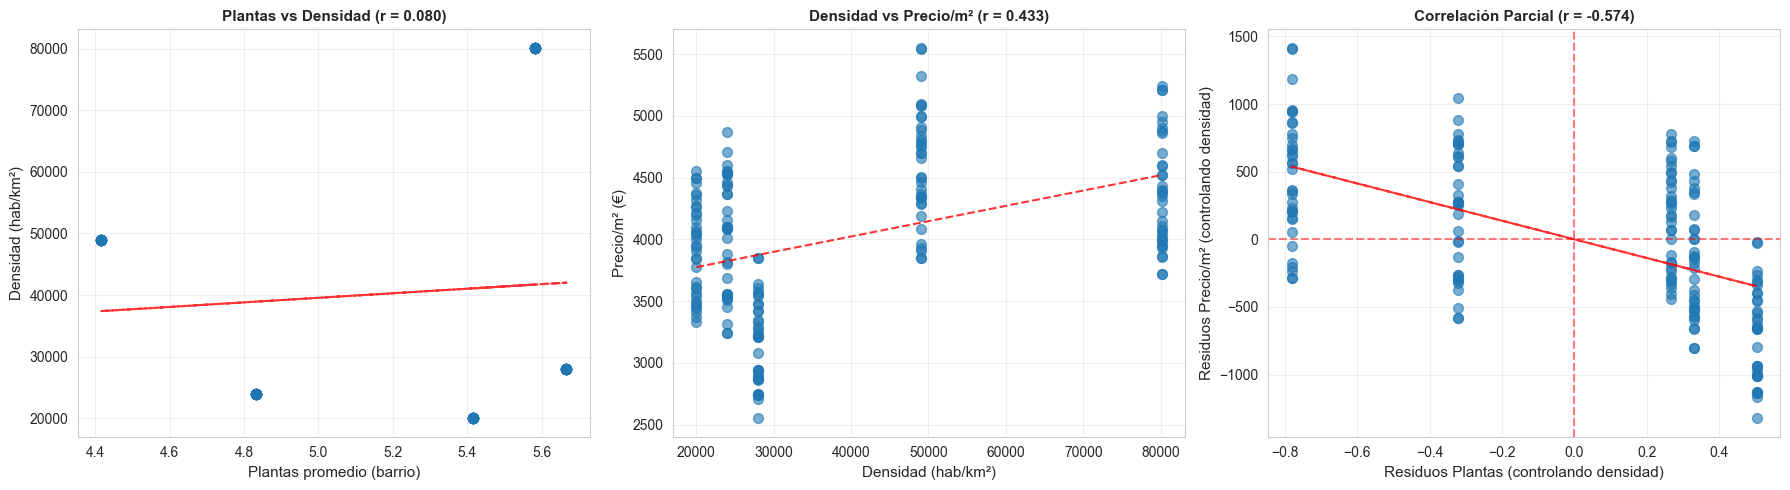


📊 Resumen de Correlaciones:
   Plantas ↔ Densidad: r = 0.0797 (p = 0.2942)
   Densidad ↔ Precio/m²: r = 0.4334 (p = 0.0000)
   Plantas ↔ Precio/m² (parcial, controlando densidad): r = -0.5741 (p = 0.0000)

📋 Interpretación:
   ✅ La correlación parcial se mantiene similar
      → El efecto de plantas NO está completamente mediado por densidad


In [95]:
# Análisis de relación plantas ↔ densidad
if 'densidad_hab_km2' in df_analysis.columns:
    # Filtrar datos válidos
    df_dens_valid = df_analysis[df_analysis['densidad_hab_km2'].notna()].copy()

    if len(df_dens_valid) > 0:
        # Correlación
        corr_plantas_densidad, p_plantas_densidad = pearsonr(
            df_dens_valid['plantas_barrio_mean'],
            df_dens_valid['densidad_hab_km2']
        )

        print(f"📊 Correlación plantas_barrio_mean ↔ densidad_hab_km2:")
        print(f"   r = {corr_plantas_densidad:.4f}, p = {p_plantas_densidad:.4f}")

        # Visualizar
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # 1. Scatter: plantas vs densidad
        axes[0].scatter(
            df_dens_valid['plantas_barrio_mean'],
            df_dens_valid['densidad_hab_km2'],
            alpha=0.6,
            s=50
        )
        axes[0].set_xlabel('Plantas promedio (barrio)', fontsize=11)
        axes[0].set_ylabel('Densidad (hab/km²)', fontsize=11)
        axes[0].set_title(f'Plantas vs Densidad (r = {corr_plantas_densidad:.3f})', fontsize=11, fontweight='bold')

        # Línea de tendencia
        z = np.polyfit(df_dens_valid['plantas_barrio_mean'], df_dens_valid['densidad_hab_km2'], 1)
        p_line = np.poly1d(z)
        axes[0].plot(df_dens_valid['plantas_barrio_mean'], p_line(df_dens_valid['plantas_barrio_mean']), "r--", alpha=0.8)
        axes[0].grid(alpha=0.3)

        # 2. Scatter: densidad vs precio/m²
        corr_densidad_precio, p_densidad_precio = pearsonr(
            df_dens_valid['densidad_hab_km2'],
            df_dens_valid['precio_m2_mean']
        )

        axes[1].scatter(
            df_dens_valid['densidad_hab_km2'],
            df_dens_valid['precio_m2_mean'],
            alpha=0.6,
            s=50
        )
        axes[1].set_xlabel('Densidad (hab/km²)', fontsize=11)
        axes[1].set_ylabel('Precio/m² (€)', fontsize=11)
        axes[1].set_title(f'Densidad vs Precio/m² (r = {corr_densidad_precio:.3f})', fontsize=11, fontweight='bold')

        z2 = np.polyfit(df_dens_valid['densidad_hab_km2'], df_dens_valid['precio_m2_mean'], 1)
        p_line2 = np.poly1d(z2)
        axes[1].plot(df_dens_valid['densidad_hab_km2'], p_line2(df_dens_valid['densidad_hab_km2']), "r--", alpha=0.8)
        axes[1].grid(alpha=0.3)

        # 3. Correlación parcial: plantas → precio (controlando densidad)
        from sklearn.linear_model import LinearRegression

        # Residuos de precio controlando por densidad
        X_dens = df_dens_valid[['densidad_hab_km2']].values
        y_precio = df_dens_valid['precio_m2_mean'].values
        y_plantas = df_dens_valid['plantas_barrio_mean'].values

        model_precio_dens = LinearRegression().fit(X_dens, y_precio)
        residuos_precio_dens = y_precio - model_precio_dens.predict(X_dens)

        # Residuos de plantas controlando por densidad
        model_plantas_dens = LinearRegression().fit(X_dens, y_plantas)
        residuos_plantas_dens = y_plantas - model_plantas_dens.predict(X_dens)

        # Correlación parcial
        corr_parcial_densidad, p_parcial_densidad = pearsonr(residuos_plantas_dens, residuos_precio_dens)

        axes[2].scatter(residuos_plantas_dens, residuos_precio_dens, alpha=0.6, s=50)
        axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
        axes[2].axvline(x=0, color='r', linestyle='--', alpha=0.5)
        axes[2].set_xlabel('Residuos Plantas (controlando densidad)', fontsize=11)
        axes[2].set_ylabel('Residuos Precio/m² (controlando densidad)', fontsize=11)
        axes[2].set_title(f'Correlación Parcial (r = {corr_parcial_densidad:.3f})', fontsize=11, fontweight='bold')

        z3 = np.polyfit(residuos_plantas_dens, residuos_precio_dens, 1)
        p_line3 = np.poly1d(z3)
        axes[2].plot(residuos_plantas_dens, p_line3(residuos_plantas_dens), "r--", alpha=0.8)
        axes[2].grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "plantas_densidad_analisis.png", dpi=150, bbox_inches='tight')
        plt.show()

        # Resumen
        print(f"\n📊 Resumen de Correlaciones:")
        print(f"   Plantas ↔ Densidad: r = {corr_plantas_densidad:.4f} (p = {p_plantas_densidad:.4f})")
        print(f"   Densidad ↔ Precio/m²: r = {corr_densidad_precio:.4f} (p = {p_densidad_precio:.4f})")
        print(f"   Plantas ↔ Precio/m² (parcial, controlando densidad): r = {corr_parcial_densidad:.4f} (p = {p_parcial_densidad:.4f})")

        # Interpretación
        print(f"\n📋 Interpretación:")
        if abs(corr_plantas_densidad) > 0.5:
            print(f"   ✅ Plantas está fuertemente correlacionado con densidad (r = {corr_plantas_densidad:.3f})")
            print(f"      → Plantas puede ser un proxy de densidad urbana")

        # Calcular correlación simple plantas-precio para comparación
        corr_simple_plantas_precio, _ = pearsonr(
            df_dens_valid['plantas_barrio_mean'],
            df_dens_valid['precio_m2_mean']
        )

        if abs(corr_parcial_densidad) < abs(corr_simple_plantas_precio) * 0.7:
            print(f"   ⚠️  La correlación parcial (controlando densidad) es menor que la simple")
            print(f"      → Parte del efecto de plantas está mediado por densidad")
            reduccion = (abs(corr_simple_plantas_precio) - abs(corr_parcial_densidad)) / abs(corr_simple_plantas_precio) * 100
            print(f"      → Reducción: {reduccion:.1f}%")
        else:
            print(f"   ✅ La correlación parcial se mantiene similar")
            print(f"      → El efecto de plantas NO está completamente mediado por densidad")
    else:
        print("⚠️  No hay datos válidos de densidad para análisis")
else:
    print("⚠️  Columna de densidad no disponible en el dataset")


### 12.3 Resumen Fase 3 y 4: Conclusiones sobre Mediadores


In [96]:
# Generar resumen de Fases 3 y 4
fases_3_4_summary = {
    'fecha': pd.Timestamp.now().isoformat(),
    'fase_3': {},
    'fase_4': {}
}

# Fase 3: Ascensor
if 'pct_edificios_con_ascensor_proxy' in df_analysis.columns:
    try:
        df_asc_valid = df_analysis[df_analysis['pct_edificios_con_ascensor_proxy'].notna()]
        if len(df_asc_valid) > 0:
            corr_plantas_asc, _ = pearsonr(
                df_asc_valid['plantas_barrio_mean'],
                df_asc_valid['pct_edificios_con_ascensor_proxy']
            )
            fases_3_4_summary['fase_3']['correlacion_plantas_ascensor'] = {
                'valor': float(corr_plantas_asc),
                'interpretacion': 'alta' if abs(corr_plantas_asc) > 0.5 else 'moderada' if abs(corr_plantas_asc) > 0.3 else 'baja'
            }
            fases_3_4_summary['fase_3']['conclusion'] = 'Plantas está correlacionado con ascensor' if abs(corr_plantas_asc) > 0.3 else 'Plantas no está correlacionado con ascensor'
    except:
        pass

# Fase 4: Densidad
if 'densidad_hab_km2' in df_analysis.columns:
    try:
        df_dens_valid = df_analysis[df_analysis['densidad_hab_km2'].notna()]
        if len(df_dens_valid) > 0:
            corr_plantas_dens, _ = pearsonr(
                df_dens_valid['plantas_barrio_mean'],
                df_dens_valid['densidad_hab_km2']
            )
            fases_3_4_summary['fase_4']['correlacion_plantas_densidad'] = {
                'valor': float(corr_plantas_dens),
                'interpretacion': 'alta' if abs(corr_plantas_dens) > 0.5 else 'moderada' if abs(corr_plantas_dens) > 0.3 else 'baja'
            }
            
            # Correlación parcial
            try:
                from sklearn.linear_model import LinearRegression
                X_dens = df_dens_valid[['densidad_hab_km2']].values
                y_precio = df_dens_valid['precio_m2_mean'].values
                y_plantas = df_dens_valid['plantas_barrio_mean'].values
                
                model_precio_dens = LinearRegression().fit(X_dens, y_precio)
                residuos_precio_dens = y_precio - model_precio_dens.predict(X_dens)
                
                model_plantas_dens = LinearRegression().fit(X_dens, y_plantas)
                residuos_plantas_dens = y_plantas - model_plantas_dens.predict(X_dens)
                
                corr_parcial_dens, _ = pearsonr(residuos_plantas_dens, residuos_precio_dens)
                
                # Calcular correlación simple plantas-precio para comparación
                corr_simple_plantas_precio, _ = pearsonr(
                    df_dens_valid['plantas_barrio_mean'],
                    df_dens_valid['precio_m2_mean']
                )
                
                fases_3_4_summary['fase_4']['correlacion_parcial_controlando_densidad'] = {
                    'valor': float(corr_parcial_dens),
                    'correlacion_simple_plantas_precio': float(corr_simple_plantas_precio),
                    'reduccion_vs_simple': float((abs(corr_simple_plantas_precio) - abs(corr_parcial_dens)) / abs(corr_simple_plantas_precio) * 100) if abs(corr_simple_plantas_precio) > 0 else 0
                }
                
                if abs(corr_parcial_dens) < abs(corr_simple_plantas_precio) * 0.7:
                    fases_3_4_summary['fase_4']['conclusion'] = 'Densidad media parcialmente el efecto de plantas'
                else:
                    fases_3_4_summary['fase_4']['conclusion'] = 'Densidad NO media completamente el efecto de plantas'
            except:
                pass
    except:
        pass

# Guardar resumen
with open(OUTPUT_DIR / "fases_3_4_mediadores_summary.json", 'w') as f:
    json.dump(fases_3_4_summary, f, indent=2, ensure_ascii=False)

print("\n" + "="*70)
print("RESUMEN FASES 3 Y 4: MEDIADORES")
print("="*70)

if 'fase_3' in fases_3_4_summary and 'correlacion_plantas_ascensor' in fases_3_4_summary['fase_3']:
    corr_asc = fases_3_4_summary['fase_3']['correlacion_plantas_ascensor']['valor']
    print(f"\n📊 Fase 3: Plantas ↔ Ascensor")
    print(f"   Correlación: r = {corr_asc:.4f}")
    print(f"   Interpretación: {fases_3_4_summary['fase_3']['correlacion_plantas_ascensor']['interpretacion']}")
    print(f"   Conclusión: {fases_3_4_summary['fase_3'].get('conclusion', 'N/A')}")

if 'fase_4' in fases_3_4_summary and 'correlacion_plantas_densidad' in fases_3_4_summary['fase_4']:
    corr_dens = fases_3_4_summary['fase_4']['correlacion_plantas_densidad']['valor']
    print(f"\n📊 Fase 4: Plantas ↔ Densidad")
    print(f"   Correlación: r = {corr_dens:.4f}")
    print(f"   Interpretación: {fases_3_4_summary['fase_4']['correlacion_plantas_densidad']['interpretacion']}")
    
    if 'correlacion_parcial_controlando_densidad' in fases_3_4_summary['fase_4']:
        corr_parcial_dens = fases_3_4_summary['fase_4']['correlacion_parcial_controlando_densidad']['valor']
        reduccion = fases_3_4_summary['fase_4']['correlacion_parcial_controlando_densidad']['reduccion_vs_simple']
        print(f"   Correlación parcial (controlando densidad): r = {corr_parcial_dens:.4f}")
        print(f"   Reducción vs correlación simple: {reduccion:.1f}%")
        print(f"   Conclusión: {fases_3_4_summary['fase_4'].get('conclusion', 'N/A')}")

print(f"\n✅ Resumen guardado: {OUTPUT_DIR / 'fases_3_4_mediadores_summary.json'}")



RESUMEN FASES 3 Y 4: MEDIADORES

📊 Fase 3: Plantas ↔ Ascensor
   Correlación: r = 0.7659
   Interpretación: alta
   Conclusión: Plantas está correlacionado con ascensor

📊 Fase 4: Plantas ↔ Densidad
   Correlación: r = 0.0797
   Interpretación: baja
   Correlación parcial (controlando densidad): r = -0.5741
   Reducción vs correlación simple: -19.3%
   Conclusión: Densidad NO media completamente el efecto de plantas

✅ Resumen guardado: ../data/processed/fases_3_4_mediadores_summary.json
